In [1]:
import numpy as np
from matplotlib import pyplot as plt
from basicpy import BaSiC
from basicpy.basicpy import FittingMode
from itertools import product
import os
# import logging
# logging.getLogger("basicpy").setLevel(level=logging.WARNING)



Bad key text.latex.unicode in file /Users/fukai/.matplotlib/stylelib/paper-default2.mplstyle, line 46 ('text.latex.unicode: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution
Duplicate key in file PosixPath('/Users/fukai/.matplotlib/stylelib/paper-default.mplstyle'), line 38 ('legend.framealpha: 1.0')
the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


# Synthetic data test

In [7]:
n_images = 8
basic = BaSiC(get_darkfield=False,lambda_flatfield_coef=100,max_reweighting_iteration=0,max_iterations=2000)

"""Generate a parabolic gradient to simulate uneven illumination"""
# Create a gradient
size = basic.working_size
grid = np.meshgrid(*(2 * (np.linspace(-size // 2 + 1, size // 2, size),)))
gradient = sum(d**2 for d in grid)
gradient = 0.01 * (np.max(gradient) - gradient) + 10
gradient_int = gradient.astype(np.uint8)

# Ground truth, for correctness checking
truth = gradient / gradient.mean()

# Create an image stack and add poisson noise
synthetic_images = np.random.poisson(lam=gradient_int.flatten(), size=(n_images, size**2)).reshape((n_images, size, size))

INFO:basicpy.basicpy:Initializing BaSiC 5105761600 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 100
max_reweighting_iteration: 0
max_iterations: 2000



INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 6.807177328482794e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 7.813276283741288e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.008817200548946857
INFO:basicpy.basicpy:elapsed time: 7.407172909999986 seconds
INFO:basicpy.basicpy:Reweighting converged.
INFO:basicpy.basicpy:=== BaSiC fit finished in 7.411612349999928 seconds ===


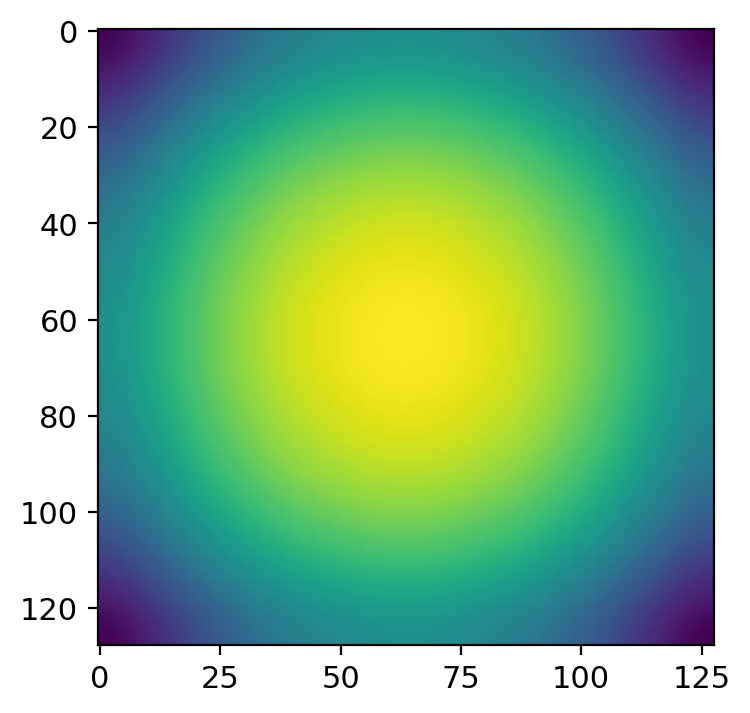

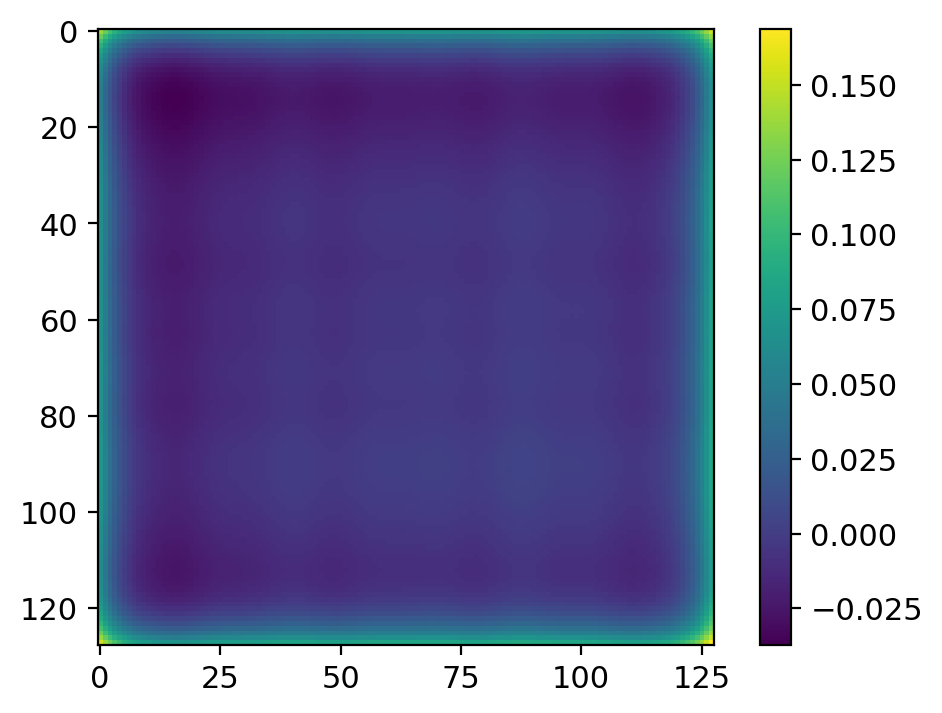

In [8]:
"""Fit with BaSiC"""
basic.fit(synthetic_images)
plt.imshow(basic.flatfield[0])
plt.show()
plt.imshow(basic.flatfield[0]-truth) ; plt.colorbar() ; plt.show()

# Exporting data for test

(147, 128, 128) uint16


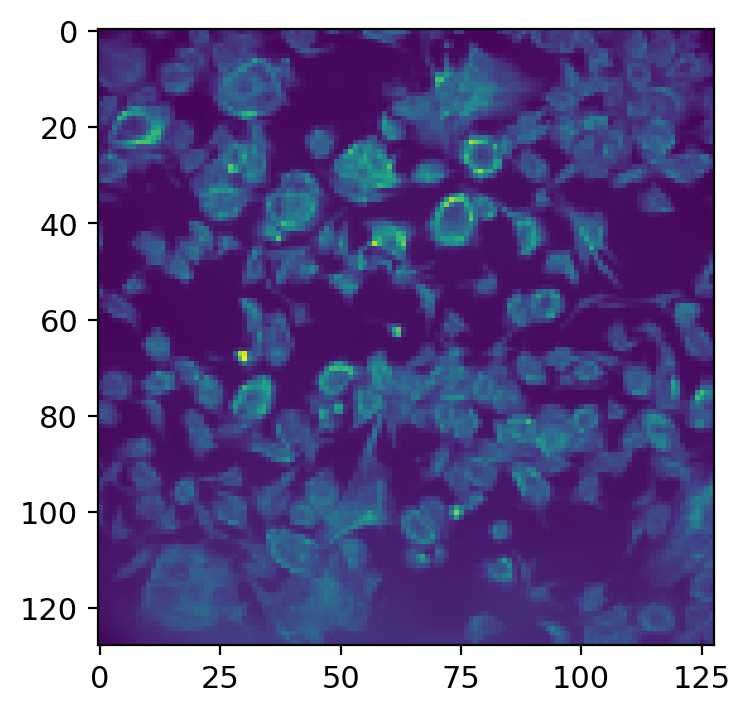

(100, 128, 171) uint8


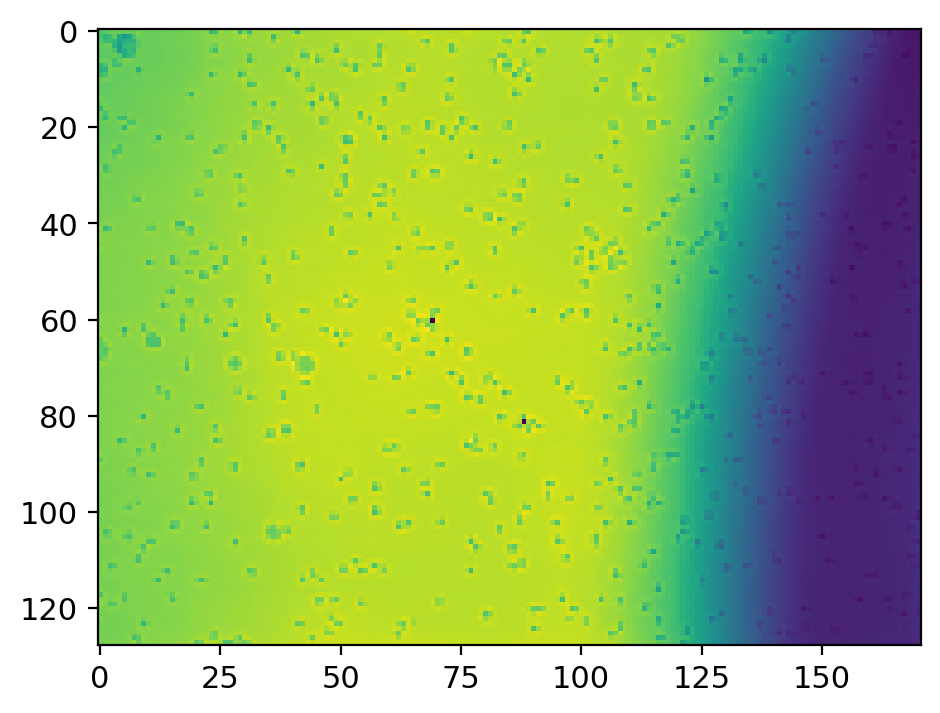

(189, 128, 171) uint8


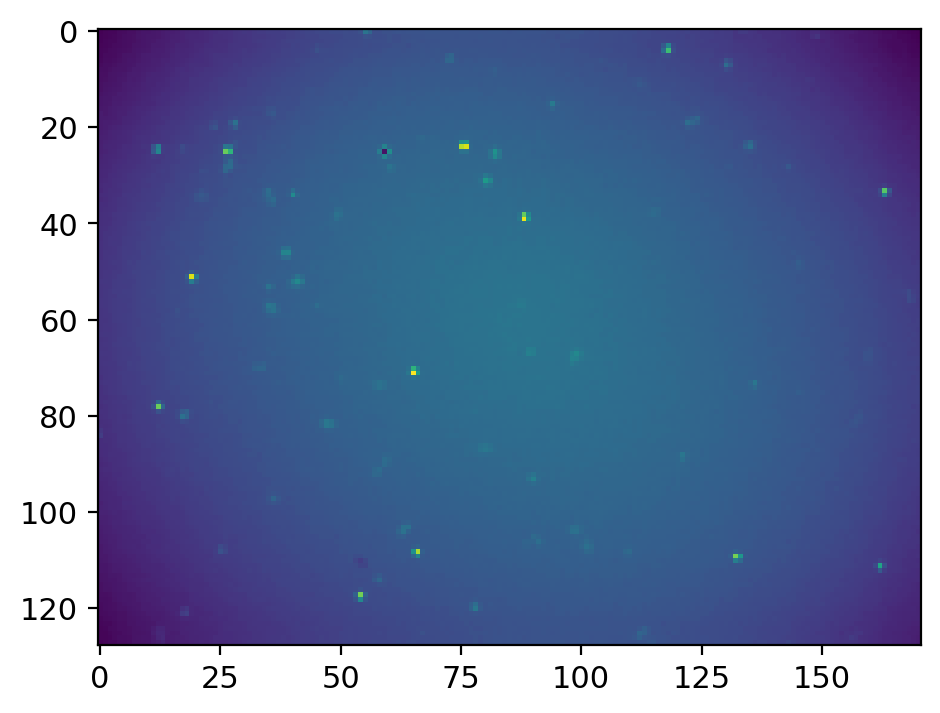

(200, 128, 171) uint8


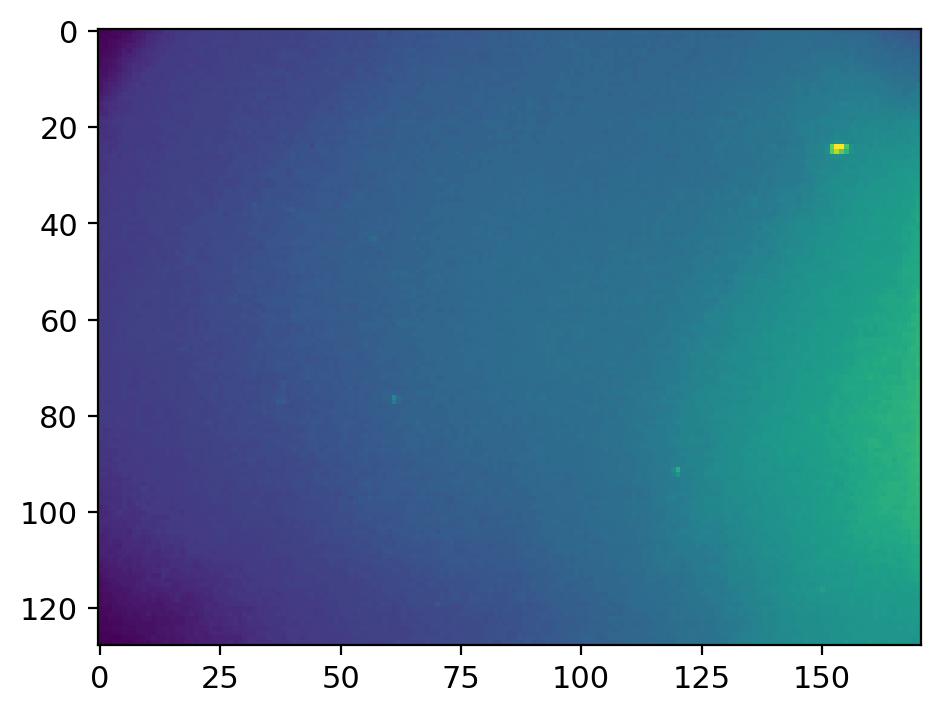

(63, 128, 128) uint16


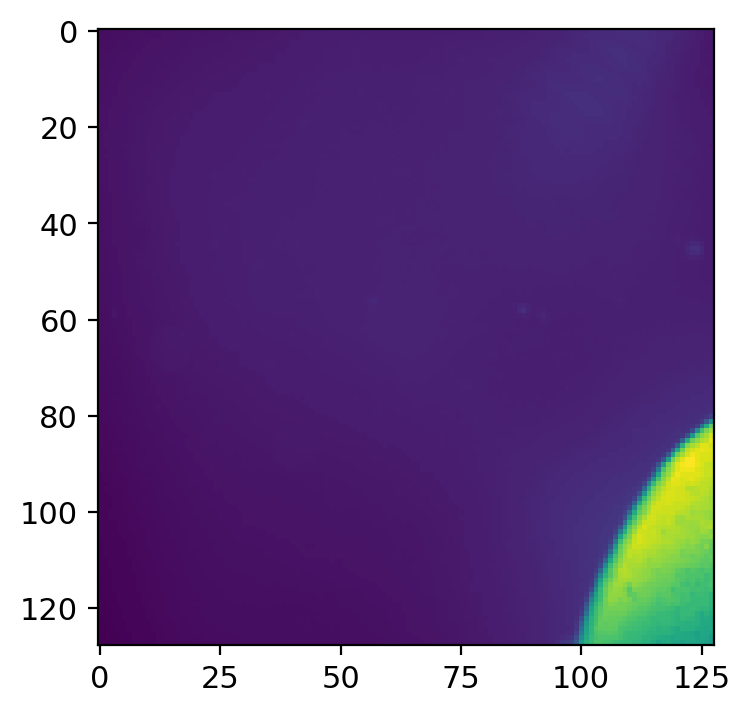

In [4]:
images = {}
keys = ["cell_culture","timelapse_brightfield","timelapse_nanog","timelapse_pu1","wsi_brain"]
for k in keys:
    d=np.load(f"../data/{k}.npz")
    im=d["images"]
    print(im.shape, im.dtype)
    plt.imshow(im[10])
    images[k]=im
    plt.show()

In [ ]:
os.makedirs("../tests/test_basic", exist_ok=True)
os.makedirs("../tests/test_basic/plots", exist_ok=True)

import logging
logging.getLogger("basicpy").setLevel(level=logging.WARNING)

figsize=3

for fitting_mode in list(FittingMode)[1:]:
    nrows=len(images)*4
    fig, axes = plt.subplots(nrows, 3, 
                             figsize=[figsize*1.5*3, figsize*nrows],
                             gridspec_kw={"hspace": 0.5, "wspace": 0.5})
    results=[]
    for j,((k,im),(get_darkfield, sort_intensity)) in \
            enumerate(product(images.items(),product([False,True],repeat=2))):
        print(j)
        b = BaSiC(fitting_mode=fitting_mode, 
    #              lambda_darkfield_coef=0.2 if fitting_mode=="approximate" else 0.2,
                  get_darkfield=get_darkfield, 
                  sort_intensity=sort_intensity)
        b.fit(im)
        for ax, res_im in zip(axes[j],[b.flatfield,b.darkfield]):
            _im=ax.imshow(res_im)
            plt.colorbar(_im,ax=ax)
        axes[j,2].plot(b.baseline)
        boolstr = lambda x:"with" if x else "without"
        k2=f"{k}_{fitting_mode.value}_{boolstr(get_darkfield)}-darkfield_{boolstr(sort_intensity)}-sort"
        axes[j,1].set_title(k2)
        results.append(dict(
                image_name=k,
                flatfield=b.flatfield,
                darkfield=b.darkfield,
                baseline=b.baseline,
                params=b.dict()
        ))
    fig.savefig(f"../tests/test_basic/plots/{fitting_mode.value}.png",bbox_inches="tight")
    np.savez_compressed(f"../tests/test_basic/{fitting_mode.value}.npz",results=results)

In [6]:
results=np.load(f"../tests/test_basic/ladmap.npz",allow_pickle=True)["results"]

In [7]:
results[0]["params"]

{'fitting_mode': <FittingMode.ladmap: 'ladmap'>,
 'epsilon': 0.1,
 'get_darkfield': False,
 'lambda_flatfield_coef': 0.00125,
 'lambda_darkfield_coef': 0.2,
 'max_iterations': 500,
 'max_reweight_iterations': 10,
 'max_reweight_iterations_baseline': 5,
 'rho': 1.5,
 'mu_coef': 12.5,
 'max_mu_coef': 10000000.0,
 'optimization_tol': 1e-06,
 'optimization_tol_diff': 0.001,
 'resize_method': <ResizeMethod.CUBIC: 4>,
 'reweighting_tol': 0.01,
 'sort_intensity': False,
 'working_size': 128}